In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/IS_Safem0de

EURUSD_H4.csv


In [ ]:
import os
data_path = '/content/drive/MyDrive/IS_Safem0de/EURUSD_H4.csv'

In [ ]:
import pandas as pd

df = pd.read_csv(data_path)
df.head()

,2009-10-05 20:00,1.46469,1.46609,1.46436,1.46558,2247
0,2009-10-06 00:00,1.46563,1.47178,1.46541,1.47035,10300
1,2009-10-06 04:00,1.47051,1.47486,1.46951,1.47169,12566
2,2009-10-06 08:00,1.47176,1.47458,1.47068,1.47264,18816
3,2009-10-06 12:00,1.47270,1.47612,1.46951,1.47416,15619
4,2009-10-06 16:00,1.47409,1.47537,1.47023,1.47160,13948


Clean + Prepare Data

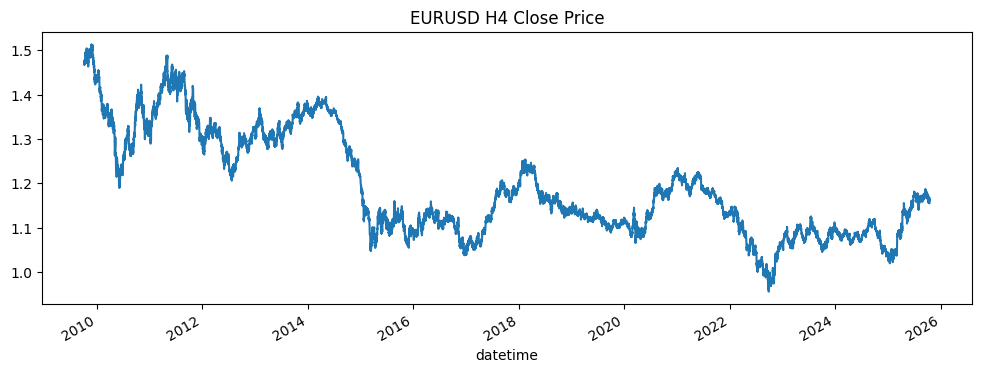

In [ ]:
# ตรวจชื่อคอลัมน์
df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']

# แปลง datetime
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')

# ตั้ง index เป็นเวลา (สะดวกกับการ plot)
df.set_index('datetime', inplace=True)

# ลอง plot ดูเพื่อเช็กข้อมูล
import matplotlib.pyplot as plt

df['close'].plot(figsize=(12,4), title='EURUSD H4 Close Price')
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['open', 'high', 'low', 'close']])

# สร้าง sequence สำหรับ LSTM
window = 50  # ใช้ 50 แท่งย้อนหลัง
X, y = [], []
for i in range(window, len(scaled)):
    X.append(scaled[i-window:i])
    y.append(scaled[i, 3])  # ใช้ค่า close เป็นเป้าหมาย

X, y = np.array(X), np.array(y)
print(f"Shape X: {X.shape}, y: {y.shape}")

Shape X: (25797, 50, 4), y: (25797,)


Train Test Split

In [ ]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 20637, Test: 5160


สร้างและเทรน LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - loss: 0.0032 - val_loss: 8.3742e-05
Epoch 2/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 33s 51ms/step - loss: 2.7872e-04 - val_loss: 7.4004e-05
Epoch 3/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 33s 50ms/step - loss: 2.1219e-04 - val_loss: 6.1510e-05
Epoch 4/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - loss: 1.8013e-04 - val_loss: 5.9316e-05
Epoch 5/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - loss: 1.5847e-04 - val_loss: 5.1414e-05
Epoch 6/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - loss: 1.2773e-04 - val_loss: 5.7991e-05
Epoch 7/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - loss: 1.3184e-04 - val_loss: 5.3022e-05
Epoch 8/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - loss: 1.1804e-04 - val_loss: 5.1439e-05
Epoch 9/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 34s 52ms/step - loss: 1.0356e-04 - val_loss: 4.3619e-05
Epoch 10/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 33s 50ms/step - loss: 1.0755e-04 - val_loss: 3.8939e-05


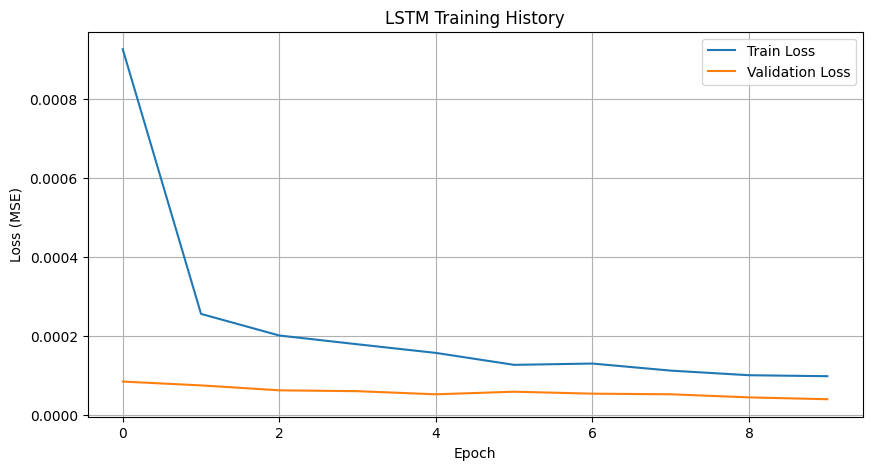

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

วิเคราะห์กราฟ Loss

🔵 Train Loss (สีน้ำเงิน): ลดลงต่อเนื่อง → แสดงว่าโมเดลกำลังเรียนรู้ pattern จากแท่งเทียนจริง ๆ

🟠 Validation Loss (สีส้ม): ต่ำกว่า train loss เล็กน้อย และนิ่ง → หมายความว่า

โมเดลไม่ได้ overfit และยัง generalize ได้ดี

✅ ไม่มีการแยกของเส้น (divergence) → คือสัญญาณดีมากสำหรับ early-stage model

ทดสอบผลการทำนาย

162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step


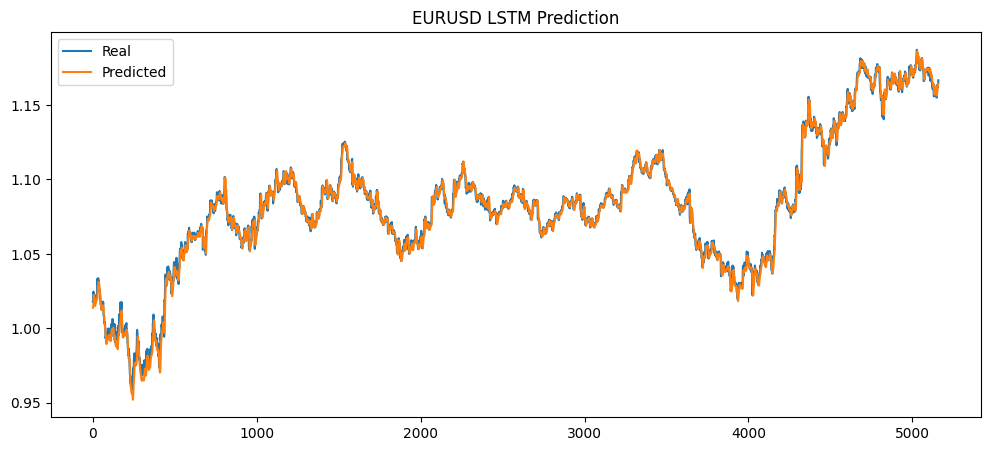

In [ ]:
predicted = model.predict(X_test)

# inverse scale กลับเป็นราคาจริง
predicted_prices = scaler.inverse_transform(
    np.concatenate((np.zeros((predicted.shape[0], 3)), predicted), axis=1)
)[:, 3]

real_prices = scaler.inverse_transform(
    np.concatenate((np.zeros((y_test.shape[0], 3)), y_test.reshape(-1,1)), axis=1)
)[:, 3]

plt.figure(figsize=(12,5))
plt.plot(real_prices, label='Real')
plt.plot(predicted_prices, label='Predicted')
plt.legend()
plt.title('EURUSD LSTM Prediction')
plt.show()

[Segment 1] 2022-08-04 04:00
Entry: 1.01788 | Pred: 1.01388
SL: 1.02297 | TP: 1.00770 | R:R=2.00

[Segment 1] 2022-08-16 04:00
Entry: 1.01595 | Pred: 1.01494
SL: 1.02103 | TP: 1.00579 | R:R=2.00

[Segment 1] 2022-08-26 08:00
Entry: 0.99972 | Pred: 0.99393
SL: 1.00472 | TP: 0.98972 | R:R=2.00

[Segment 1] 2022-09-07 08:00
Entry: 0.98782 | Pred: 0.98665
SL: 0.99276 | TP: 0.97794 | R:R=2.00

[Segment 1] 2022-09-19 08:00
Entry: 0.99821 | Pred: 0.99765
SL: 1.00320 | TP: 0.98823 | R:R=2.00

[Segment 1] 2022-09-29 12:00
Entry: 0.97733 | Pred: 0.96450
SL: 0.98222 | TP: 0.96756 | R:R=2.00

[Segment 1] 2022-10-11 12:00
Entry: 0.97558 | Pred: 0.96500
SL: 0.98046 | TP: 0.96582 | R:R=2.00

[Segment 1] 2022-10-21 16:00
Entry: 0.98616 | Pred: 0.97381
SL: 0.99109 | TP: 0.97630 | R:R=2.00

[Segment 1] 2022-11-02 16:00
Entry: 0.98285 | Pred: 0.98484
SL: 0.97794 | TP: 0.99268 | R:R=2.00

[Segment 1] 2022-11-14 16:00
Entry: 1.03533 | Pred: 1.03035
SL: 1.04051 | TP: 1.02498 | R:R=2.00



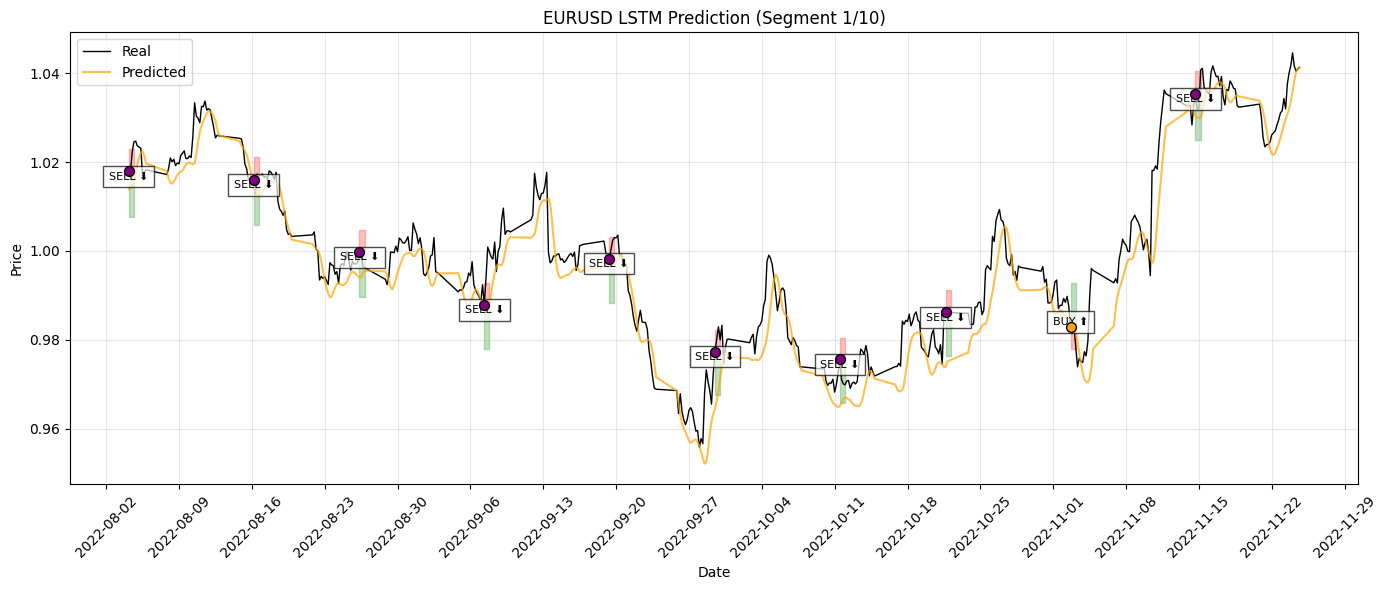

[Segment 2] 2022-11-24 20:00
Entry: 1.04074 | Pred: 1.04098
SL: 1.03554 | TP: 1.05115 | R:R=2.00

[Segment 2] 2022-12-06 20:00
Entry: 1.04671 | Pred: 1.04785
SL: 1.04148 | TP: 1.05718 | R:R=2.00

[Segment 2] 2022-12-18 20:00
Entry: 1.05842 | Pred: 1.06078
SL: 1.05313 | TP: 1.06900 | R:R=2.00

[Segment 2] 2022-12-29 00:00
Entry: 1.06230 | Pred: 1.06219
SL: 1.06761 | TP: 1.05168 | R:R=2.00

[Segment 2] 2023-01-10 00:00
Entry: 1.07321 | Pred: 1.07283
SL: 1.07858 | TP: 1.06248 | R:R=2.00

[Segment 2] 2023-01-20 04:00
Entry: 1.08399 | Pred: 1.08204
SL: 1.08941 | TP: 1.07315 | R:R=2.00

[Segment 2] 2023-02-01 04:00
Entry: 1.08798 | Pred: 1.08544
SL: 1.09342 | TP: 1.07710 | R:R=2.00

[Segment 2] 2023-02-13 04:00
Entry: 1.06828 | Pred: 1.06640
SL: 1.07362 | TP: 1.05760 | R:R=2.00

[Segment 2] 2023-02-23 08:00
Entry: 1.06038 | Pred: 1.06058
SL: 1.05508 | TP: 1.07098 | R:R=2.00

[Segment 2] 2023-03-07 08:00
Entry: 1.06565 | Pred: 1.06791
SL: 1.06032 | TP: 1.07631 | R:R=2.00



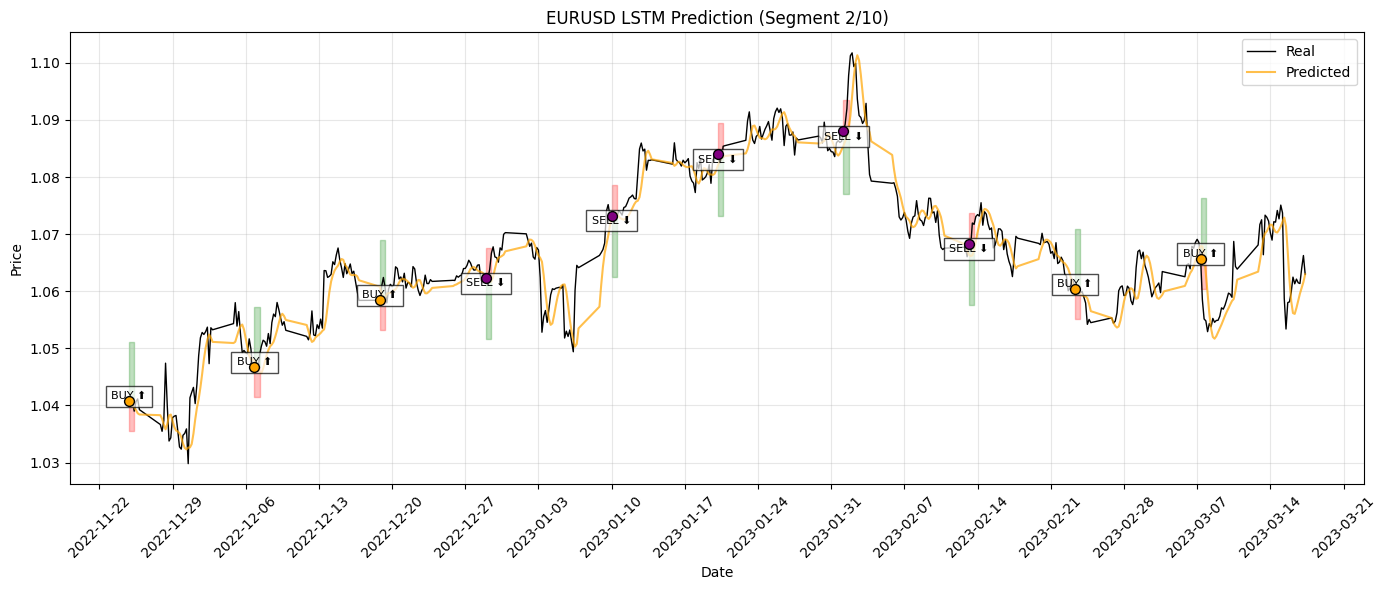

[Segment 3] 2023-03-17 12:00
Entry: 1.06462 | Pred: 1.06386
SL: 1.06994 | TP: 1.05397 | R:R=2.00

[Segment 3] 2023-03-29 12:00
Entry: 1.08249 | Pred: 1.08403
SL: 1.07708 | TP: 1.09331 | R:R=2.00

[Segment 3] 2023-04-10 12:00
Entry: 1.08391 | Pred: 1.09004
SL: 1.07849 | TP: 1.09475 | R:R=2.00

[Segment 3] 2023-04-20 16:00
Entry: 1.09634 | Pred: 1.09598
SL: 1.10182 | TP: 1.08538 | R:R=2.00

[Segment 3] 2023-05-02 16:00
Entry: 1.10057 | Pred: 1.09752
SL: 1.10607 | TP: 1.08956 | R:R=2.00

[Segment 3] 2023-05-12 20:00
Entry: 1.08477 | Pred: 1.08833
SL: 1.07935 | TP: 1.09562 | R:R=2.00

[Segment 3] 2023-05-24 20:00
Entry: 1.07555 | Pred: 1.07674
SL: 1.07017 | TP: 1.08631 | R:R=2.00

[Segment 3] 2023-06-05 20:00
Entry: 1.07113 | Pred: 1.06887
SL: 1.07649 | TP: 1.06042 | R:R=2.00

[Segment 3] 2023-06-16 00:00
Entry: 1.09381 | Pred: 1.09012
SL: 1.09928 | TP: 1.08287 | R:R=2.00

[Segment 3] 2023-06-28 00:00
Entry: 1.09508 | Pred: 1.09571
SL: 1.08960 | TP: 1.10603 | R:R=2.00



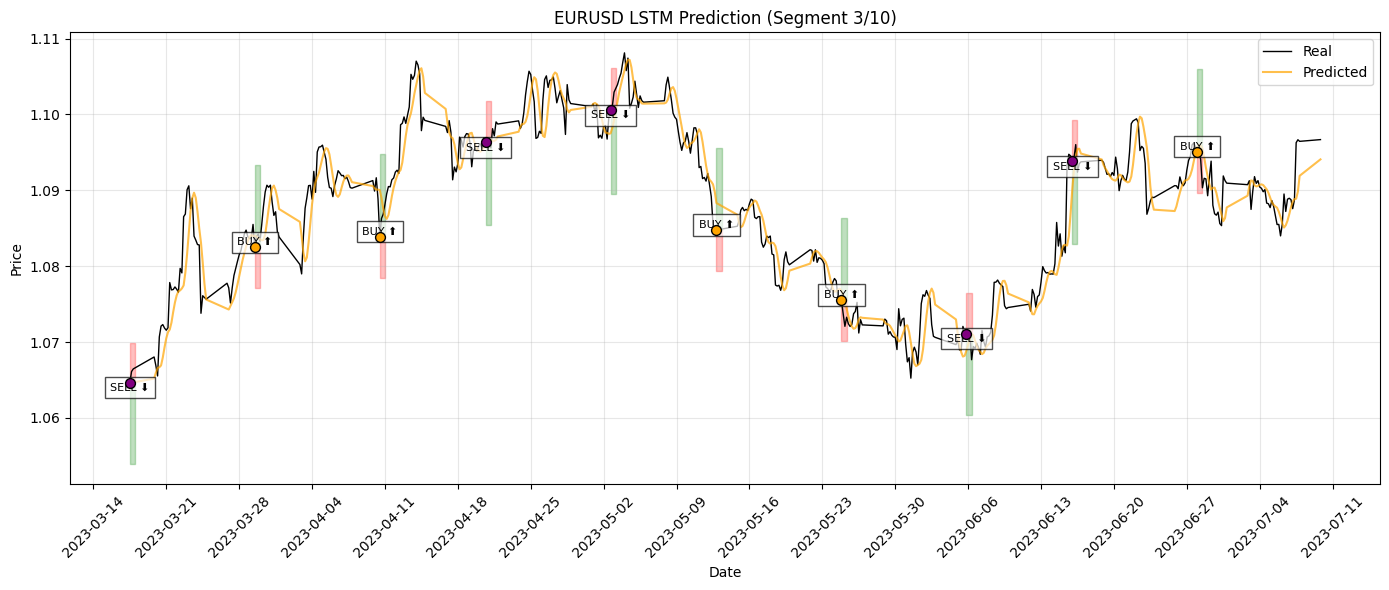

[Segment 4] 2023-07-10 00:00
Entry: 1.09559 | Pred: 1.09575
SL: 1.09011 | TP: 1.10655 | R:R=2.00

[Segment 4] 2023-07-20 04:00
Entry: 1.12054 | Pred: 1.12023
SL: 1.12614 | TP: 1.10933 | R:R=2.00

[Segment 4] 2023-08-01 04:00
Entry: 1.09796 | Pred: 1.10045
SL: 1.09247 | TP: 1.10894 | R:R=2.00

[Segment 4] 2023-08-11 08:00
Entry: 1.09973 | Pred: 1.09924
SL: 1.10523 | TP: 1.08873 | R:R=2.00

[Segment 4] 2023-08-23 08:00
Entry: 1.08111 | Pred: 1.08396
SL: 1.07570 | TP: 1.09192 | R:R=2.00

[Segment 4] 2023-09-04 08:00
Entry: 1.08001 | Pred: 1.07741
SL: 1.08541 | TP: 1.06921 | R:R=2.00

[Segment 4] 2023-09-14 12:00
Entry: 1.06587 | Pred: 1.07310
SL: 1.06054 | TP: 1.07653 | R:R=2.00

[Segment 4] 2023-09-26 12:00
Entry: 1.05724 | Pred: 1.05762
SL: 1.05195 | TP: 1.06781 | R:R=2.00

[Segment 4] 2023-10-06 16:00
Entry: 1.05897 | Pred: 1.05458
SL: 1.06426 | TP: 1.04838 | R:R=2.00

[Segment 4] 2023-10-18 16:00
Entry: 1.05354 | Pred: 1.05612
SL: 1.04827 | TP: 1.06408 | R:R=2.00



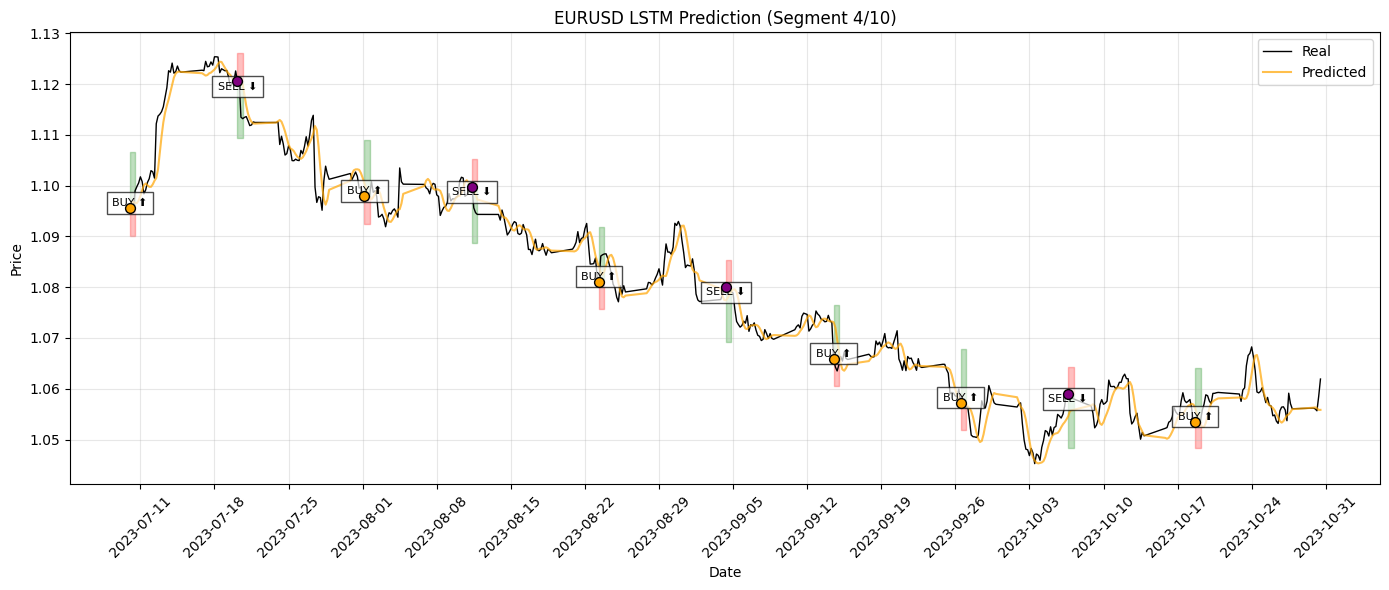

[Segment 5] 2023-10-30 16:00
Entry: 1.06169 | Pred: 1.05673
SL: 1.06700 | TP: 1.05107 | R:R=2.00

[Segment 5] 2023-11-09 20:00
Entry: 1.06669 | Pred: 1.06964
SL: 1.06136 | TP: 1.07736 | R:R=2.00

[Segment 5] 2023-11-21 20:00
Entry: 1.09169 | Pred: 1.09385
SL: 1.08623 | TP: 1.10261 | R:R=2.00

[Segment 5] 2023-12-03 20:00
Entry: 1.08857 | Pred: 1.08718
SL: 1.09401 | TP: 1.07768 | R:R=2.00

[Segment 5] 2023-12-14 00:00
Entry: 1.09058 | Pred: 1.08239
SL: 1.09603 | TP: 1.07967 | R:R=2.00

[Segment 5] 2023-12-26 12:00
Entry: 1.10249 | Pred: 1.10154
SL: 1.10800 | TP: 1.09147 | R:R=2.00

[Segment 5] 2024-01-08 12:00
Entry: 1.09697 | Pred: 1.09423
SL: 1.10245 | TP: 1.08600 | R:R=2.00

[Segment 5] 2024-01-18 16:00
Entry: 1.08617 | Pred: 1.08891
SL: 1.08074 | TP: 1.09703 | R:R=2.00

[Segment 5] 2024-01-30 16:00
Entry: 1.08459 | Pred: 1.08300
SL: 1.09001 | TP: 1.07374 | R:R=2.00

[Segment 5] 2024-02-09 20:00
Entry: 1.07821 | Pred: 1.07752
SL: 1.08360 | TP: 1.06743 | R:R=2.00



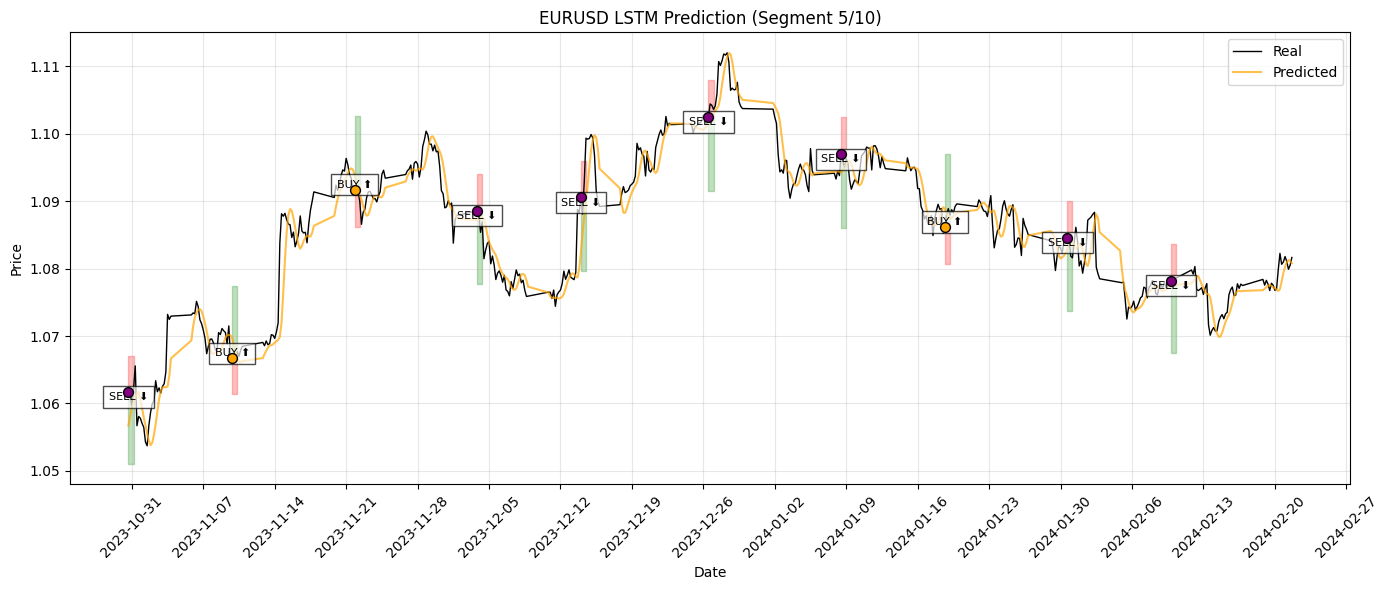

[Segment 6] 2024-02-21 20:00
Entry: 1.08202 | Pred: 1.08062
SL: 1.08743 | TP: 1.07120 | R:R=2.00

[Segment 6] 2024-03-04 20:00
Entry: 1.08541 | Pred: 1.08546
SL: 1.07998 | TP: 1.09626 | R:R=2.00

[Segment 6] 2024-03-15 00:00
Entry: 1.08769 | Pred: 1.09016
SL: 1.08225 | TP: 1.09857 | R:R=2.00

[Segment 6] 2024-03-27 00:00
Entry: 1.08261 | Pred: 1.08367
SL: 1.07720 | TP: 1.09344 | R:R=2.00

[Segment 6] 2024-04-08 00:00
Entry: 1.08333 | Pred: 1.08267
SL: 1.08875 | TP: 1.07250 | R:R=2.00

[Segment 6] 2024-04-18 04:00
Entry: 1.06810 | Pred: 1.06591
SL: 1.07344 | TP: 1.05742 | R:R=2.00

[Segment 6] 2024-04-30 04:00
Entry: 1.07051 | Pred: 1.07130
SL: 1.06516 | TP: 1.08122 | R:R=2.00

[Segment 6] 2024-05-10 08:00
Entry: 1.07792 | Pred: 1.07758
SL: 1.08331 | TP: 1.06714 | R:R=2.00

[Segment 6] 2024-05-22 08:00
Entry: 1.08274 | Pred: 1.08534
SL: 1.07733 | TP: 1.09357 | R:R=2.00

[Segment 6] 2024-06-03 08:00
Entry: 1.08432 | Pred: 1.08494
SL: 1.07890 | TP: 1.09516 | R:R=2.00



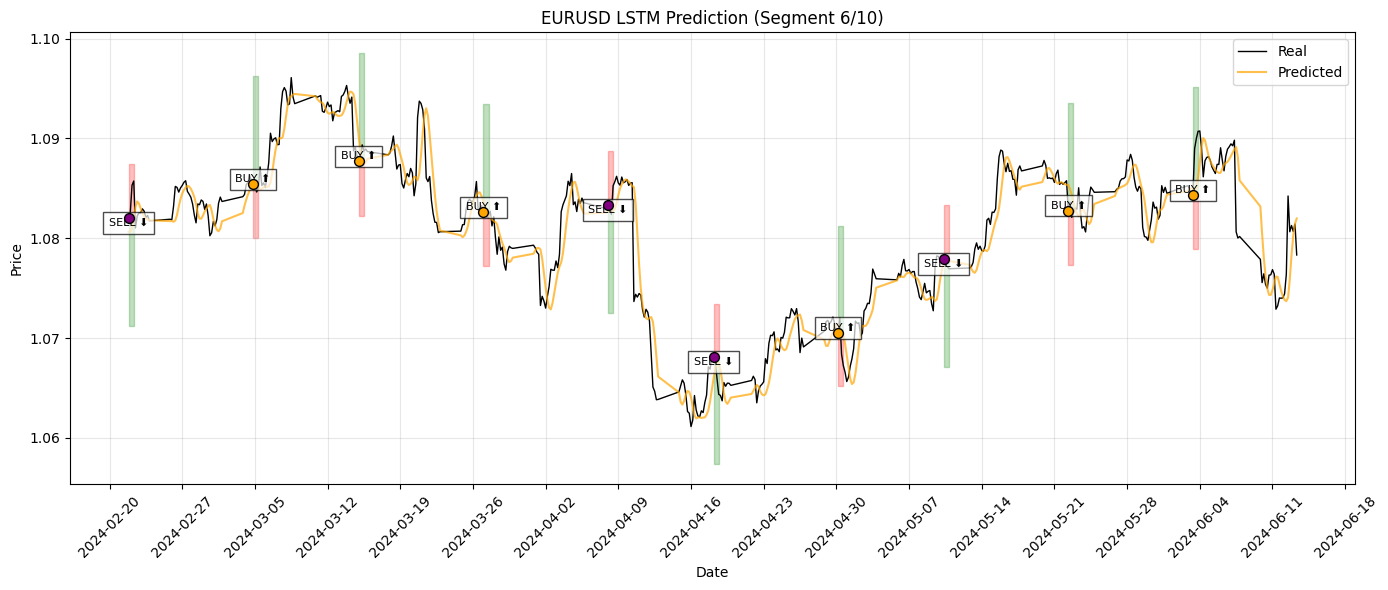

[Segment 7] 2024-06-13 12:00
Entry: 1.07553 | Pred: 1.08167
SL: 1.07015 | TP: 1.08629 | R:R=2.00

[Segment 7] 2024-06-25 12:00
Entry: 1.07039 | Pred: 1.07310
SL: 1.06504 | TP: 1.08109 | R:R=2.00

[Segment 7] 2024-07-05 16:00
Entry: 1.08414 | Pred: 1.08183
SL: 1.08956 | TP: 1.07330 | R:R=2.00

[Segment 7] 2024-07-17 16:00
Entry: 1.09362 | Pred: 1.09158
SL: 1.09909 | TP: 1.08268 | R:R=2.00

[Segment 7] 2024-07-29 16:00
Entry: 1.08237 | Pred: 1.08358
SL: 1.07696 | TP: 1.09319 | R:R=2.00

[Segment 7] 2024-08-08 20:00
Entry: 1.09149 | Pred: 1.09219
SL: 1.08603 | TP: 1.10240 | R:R=2.00

[Segment 7] 2024-08-20 20:00
Entry: 1.11275 | Pred: 1.10947
SL: 1.11831 | TP: 1.10162 | R:R=2.00

[Segment 7] 2024-09-01 20:00
Entry: 1.10446 | Pred: 1.10649
SL: 1.09894 | TP: 1.11550 | R:R=2.00

[Segment 7] 2024-09-12 00:00
Entry: 1.10136 | Pred: 1.10273
SL: 1.09585 | TP: 1.11237 | R:R=2.00

[Segment 7] 2024-09-24 00:00
Entry: 1.11126 | Pred: 1.11135
SL: 1.10570 | TP: 1.12237 | R:R=2.00



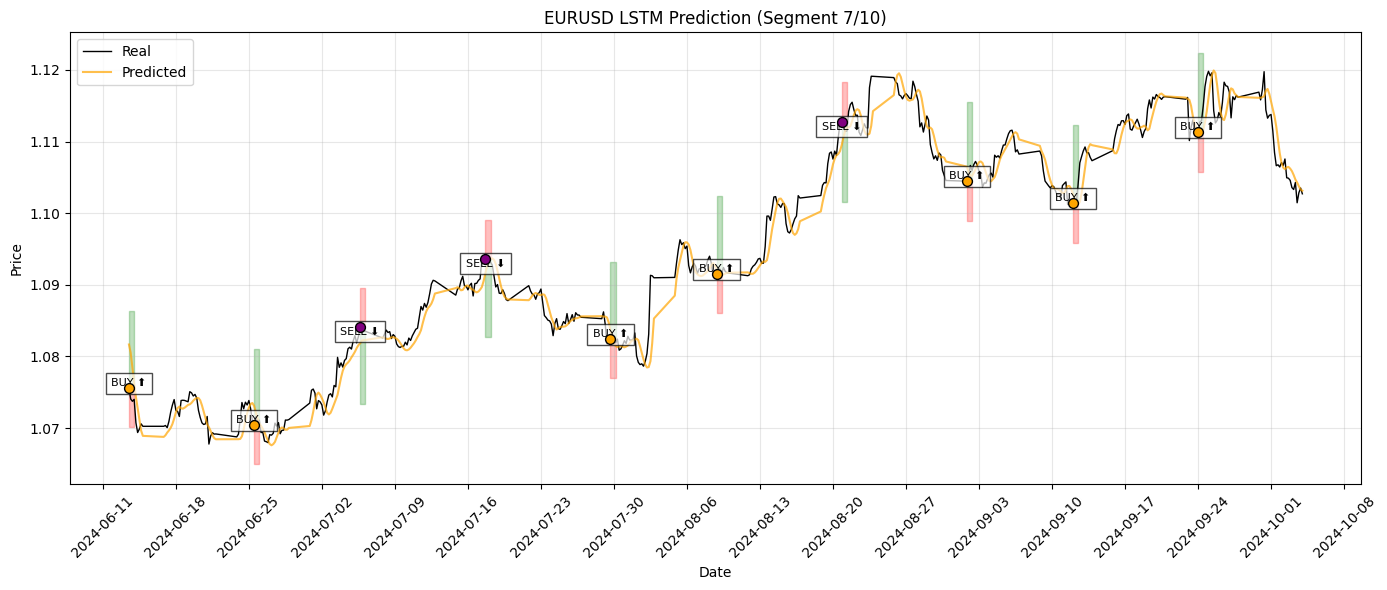

[Segment 8] 2024-10-04 04:00
Entry: 1.10278 | Pred: 1.10315
SL: 1.09727 | TP: 1.11381 | R:R=2.00

[Segment 8] 2024-10-16 04:00
Entry: 1.08821 | Pred: 1.08912
SL: 1.08277 | TP: 1.09909 | R:R=2.00

[Segment 8] 2024-10-28 04:00
Entry: 1.08042 | Pred: 1.07915
SL: 1.08582 | TP: 1.06962 | R:R=2.00

[Segment 8] 2024-11-07 08:00
Entry: 1.07589 | Pred: 1.07166
SL: 1.08127 | TP: 1.06513 | R:R=2.00

[Segment 8] 2024-11-19 08:00
Entry: 1.05619 | Pred: 1.05851
SL: 1.05091 | TP: 1.06675 | R:R=2.00

[Segment 8] 2024-11-29 12:00
Entry: 1.05612 | Pred: 1.05556
SL: 1.06140 | TP: 1.04556 | R:R=2.00

[Segment 8] 2024-12-11 12:00
Entry: 1.04906 | Pred: 1.05015
SL: 1.04381 | TP: 1.05955 | R:R=2.00

[Segment 8] 2024-12-23 12:00
Entry: 1.03908 | Pred: 1.04223
SL: 1.03388 | TP: 1.04947 | R:R=2.00

[Segment 8] 2025-01-05 20:00
Entry: 1.03051 | Pred: 1.02740
SL: 1.03566 | TP: 1.02020 | R:R=2.00

[Segment 8] 2025-01-16 00:00
Entry: 1.02888 | Pred: 1.02863
SL: 1.03402 | TP: 1.01859 | R:R=2.00



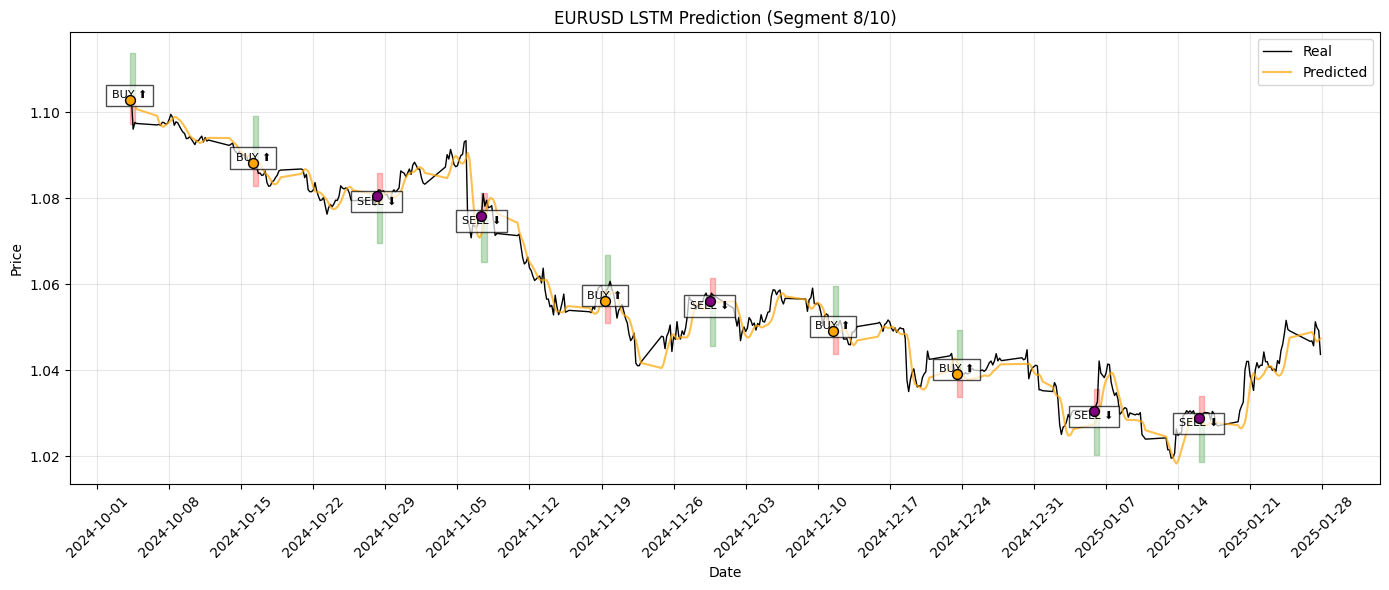

[Segment 9] 2025-01-28 00:00
Entry: 1.04292 | Pred: 1.04705
SL: 1.03771 | TP: 1.05335 | R:R=2.00

[Segment 9] 2025-02-07 04:00
Entry: 1.03891 | Pred: 1.03577
SL: 1.04410 | TP: 1.02852 | R:R=2.00

[Segment 9] 2025-02-19 04:00
Entry: 1.04511 | Pred: 1.04368
SL: 1.05034 | TP: 1.03466 | R:R=2.00

[Segment 9] 2025-03-03 04:00
Entry: 1.04054 | Pred: 1.03829
SL: 1.04574 | TP: 1.03013 | R:R=2.00

[Segment 9] 2025-03-13 08:00
Entry: 1.08560 | Pred: 1.08796
SL: 1.08017 | TP: 1.09646 | R:R=2.00

[Segment 9] 2025-03-25 08:00
Entry: 1.08176 | Pred: 1.07991
SL: 1.08717 | TP: 1.07094 | R:R=2.00

[Segment 9] 2025-04-04 12:00
Entry: 1.10082 | Pred: 1.10574
SL: 1.09532 | TP: 1.11183 | R:R=2.00

[Segment 9] 2025-04-16 12:00
Entry: 1.13813 | Pred: 1.13279
SL: 1.14382 | TP: 1.12675 | R:R=2.00

[Segment 9] 2025-04-28 12:00
Entry: 1.13862 | Pred: 1.13582
SL: 1.14431 | TP: 1.12723 | R:R=2.00

[Segment 9] 2025-05-08 16:00
Entry: 1.12259 | Pred: 1.12893
SL: 1.11698 | TP: 1.13382 | R:R=2.00



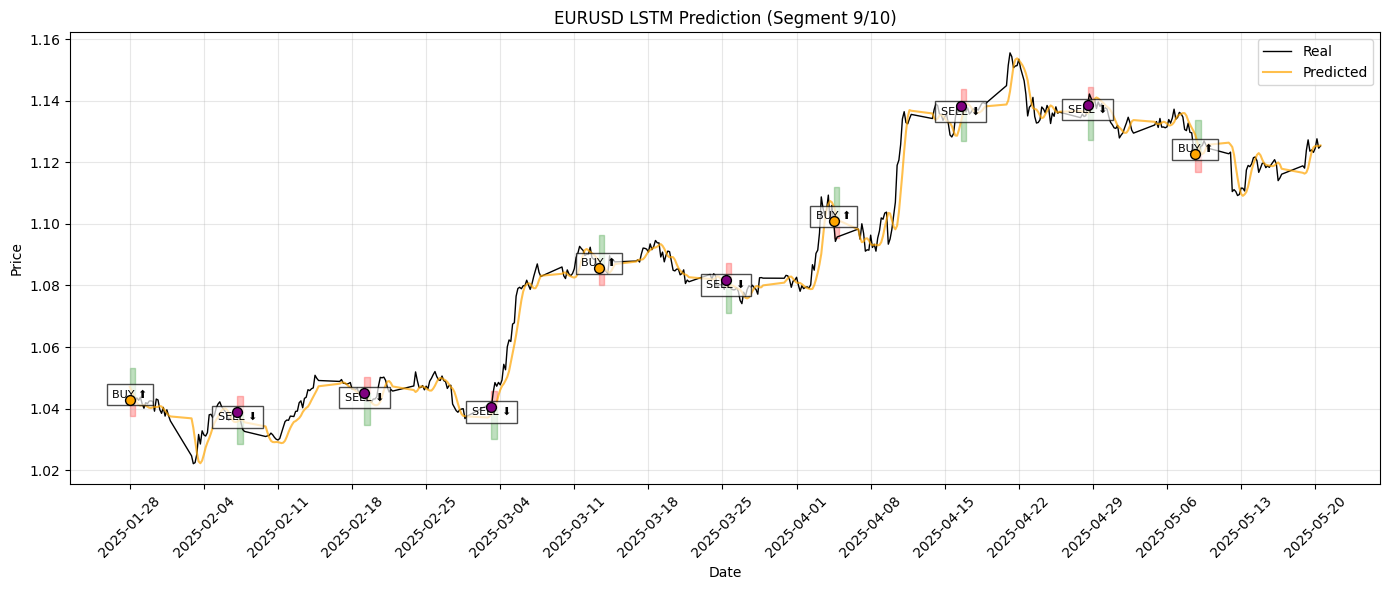

[Segment 10] 2025-05-20 16:00
Entry: 1.12804 | Pred: 1.12535
SL: 1.13368 | TP: 1.11676 | R:R=2.00

[Segment 10] 2025-05-30 20:00
Entry: 1.13453 | Pred: 1.13544
SL: 1.12886 | TP: 1.14588 | R:R=2.00

[Segment 10] 2025-06-11 20:00
Entry: 1.15099 | Pred: 1.14560
SL: 1.15674 | TP: 1.13948 | R:R=2.00

[Segment 10] 2025-06-23 20:00
Entry: 1.15979 | Pred: 1.15112
SL: 1.16559 | TP: 1.14819 | R:R=2.00

[Segment 10] 2025-07-04 00:00
Entry: 1.17701 | Pred: 1.17620
SL: 1.18290 | TP: 1.16524 | R:R=2.00

[Segment 10] 2025-07-16 00:00
Entry: 1.16108 | Pred: 1.16318
SL: 1.15527 | TP: 1.17269 | R:R=2.00

[Segment 10] 2025-07-28 00:00
Entry: 1.17562 | Pred: 1.17374
SL: 1.18150 | TP: 1.16386 | R:R=2.00

[Segment 10] 2025-08-07 04:00
Entry: 1.16897 | Pred: 1.16532
SL: 1.17481 | TP: 1.15728 | R:R=2.00

[Segment 10] 2025-08-19 04:00
Entry: 1.16834 | Pred: 1.16601
SL: 1.17418 | TP: 1.15666 | R:R=2.00

[Segment 10] 2025-08-29 08:00
Entry: 1.16627 | Pred: 1.16801
SL: 1.16044 | TP: 1.17793 | R:R=2.00



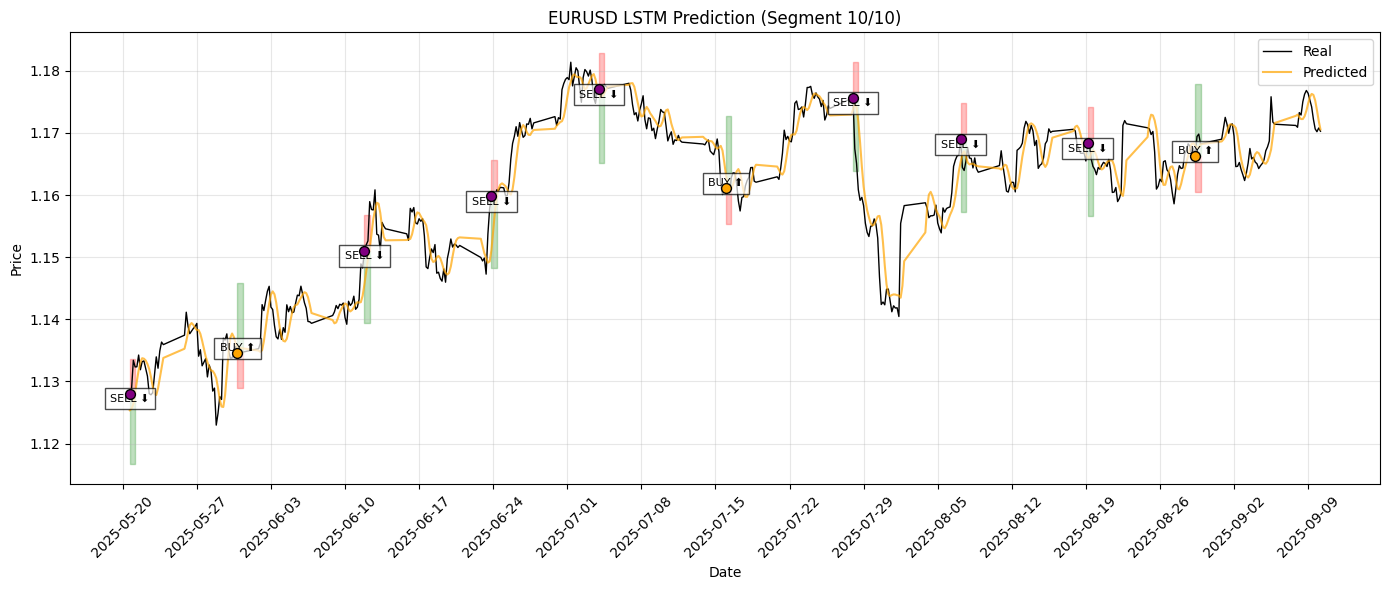

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

# พารามิเตอร์
risk_pct = 0.005
reward_pct = 0.01
signals = np.where(predicted_prices > real_prices, 1, -1)
dates = df.index[-len(real_prices):]

segment_size = 500  # จำนวนแท่งต่อภาพ
num_segments = len(real_prices) // segment_size

for seg in range(num_segments):
    start = seg * segment_size
    end = start + segment_size

    seg_dates = dates[start:end]
    seg_real = real_prices[start:end]
    seg_pred = predicted_prices[start:end]
    seg_signals = signals[start:end]

    plt.figure(figsize=(14, 6))
    plt.plot(seg_dates, seg_real, label='Real', color='black', linewidth=1)
    plt.plot(seg_dates, seg_pred, label='Predicted', color='orange', alpha=0.7)

    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)

    for i in range(0, len(seg_real), 50):  # plot ทุก 50 จุดใน segment
        entry_price = seg_real[i]
        predicted_next = seg_pred[i]
        entry_time = seg_dates[i]
        direction = seg_signals[i]

        if direction == 1:  # BUY
            stop_loss = entry_price * (1 - risk_pct)
            take_profit = entry_price * (1 + reward_pct)
            label = 'BUY ⬆️'
        else:  # SELL
            stop_loss = entry_price * (1 + risk_pct)
            take_profit = entry_price * (1 - reward_pct)
            label = 'SELL ⬇️'

        reward = abs(take_profit - entry_price)
        risk = abs(entry_price - stop_loss)
        rr_ratio = reward / risk

        # Print trade summary
        print(f"[Segment {seg+1}] {entry_time:%Y-%m-%d %H:%M}")
        print(f"Entry: {entry_price:.5f} | Pred: {predicted_next:.5f}")
        print(f"SL: {stop_loss:.5f} | TP: {take_profit:.5f} | R:R={rr_ratio:.2f}\n")

        # Risk (แดง)
        plt.fill_between([entry_time, entry_time + pd.Timedelta(hours=12)],
                         entry_price, stop_loss, color='red', alpha=0.25)
        # Reward (เขียว)
        plt.fill_between([entry_time, entry_time + pd.Timedelta(hours=12)],
                         entry_price, take_profit, color='green', alpha=0.25)

        plt.scatter(entry_time, entry_price,
                    color='orange' if direction == 1 else 'purple',
                    s=50, edgecolor='black', zorder=5)
        plt.text(entry_time, entry_price, label,
                 fontsize=8, ha='center',
                 va='bottom' if direction == 1 else 'top',
                 color='black', bbox=dict(facecolor='white', alpha=0.7))

    plt.title(f"EURUSD LSTM Prediction (Segment {seg+1}/{num_segments})")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [ ]:
!pip install twelvedata
!pip install schedule

In [ ]:
from twelvedata import TDClient
import pandas as pd
import time
import schedule

# ตั้งค่า
API_KEY = "demo"  # หรือ key ของคุณ
SYMBOL = "EUR/USD"

td = TDClient(apikey=API_KEY)

def fetch_data():
    data = td.time_series(
        symbol=SYMBOL,
        interval="30min",
        outputsize=100
    ).as_pandas()


    # เตรียมข้อมูล
    data = data.rename(columns=str.lower)
    data.index = pd.to_datetime(data.index)
    data.sort_index(inplace=True)

    print(f"[{pd.Timestamp.now()}] ดึงข้อมูลสำเร็จ {len(data)} แท่ง")
    print(data.tail(3))
    return data

# ทดสอบเรียกครั้งเดียว
df = fetch_data()

[2025-10-16 09:15:51.989323] ดึงข้อมูลสำเร็จ 100 แท่ง
                        open     high      low    close
datetime                                               
2025-10-16 19:00:00  1.16518  1.16587  1.16486  1.16561
2025-10-16 19:30:00  1.16562  1.16599  1.16542  1.16588
2025-10-16 20:00:00  1.16588  1.16602  1.16558  1.16580
